In [1]:
library(tidyverse) #for multi-purpose data transformation and visualization
library(sf) #to work with spatial objects
library(here) #to manage the path to the main folder
library("rnaturalearth") #to retrieve background maps for visualization
library("rnaturalearthdata") #background maps data

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Linking to GEOS 3.9.0, GDAL 3.2.1, PROJ 7.2.1

here() starts at C:/Users/Angel/Documents/VIZZUALITY_CHALLENGE



First step is setting up the path to the work folder and the data

In [2]:
path <- here()
path_data <- file.path(path, "data")


Then, creating a list of the csv files of interest. Since I am going to focus on the differences between the technologies used in harvesting, I omitted those ending with "TA" or "TR", as according to the readme they correspond to all the technologies combined (TA) and all the rainfed technologies (TR).

In [5]:
data_csv_list <- list.files(path_data, ".csv", full.names = T) %>% grep("_TA|_TR",., invert = T, value = T)
basename(data_csv_list)

[1] "spam2010V2r0_global_A_TH.csv" "spam2010V2r0_global_A_TI.csv"
[3] "spam2010V2r0_global_A_TL.csv" "spam2010V2r0_global_A_TS.csv"

I then create a "dictionary" (named list) with the equivalences between the suffix on the file name and the technology used (in the original files, the field corresponding with this information often has empty values)

In [6]:
tech_types <- list("TA" = "all technologies",
                    "TI" = "Irrigated",
                    "TH" = "Rainfed high input",
                    "TL" = "Rainfed low input",
                    "TS" = "Rainfed subsistance",
                    "TR" = "Rainfed total")

I then looped through the data files to:  
- select only the desired variables (soy surface, coordinates and a few more just in case)  
- retrieve only the records with soy harvested surface  
- include the type of technology as a variable  
- combine the files into a single data.frame  

Doing this using `apply` with a custom function resulted in similar processing times, and loops like this are usually easier to read and debug

In [9]:
t1 <- Sys.time()
for(i in 1:length(data_csv_list)){
  print(basename(data_csv_list[i]))
  df_1 <- read.csv(data_csv_list[i], quote = "")
  
  var_soy <- grep("soyb", names(df_1), value = T)
  
  df_clean <- df_1[, c("x", "y", "rec_type", "tech_type", var_soy,
                       "year_data", "source", "name_cntr", "name_adm1")]
  
  names(df_clean)[names(df_clean) == var_soy] <- "soy_beans"
  
  df_clean <- filter(df_clean, soy_beans > 0)
  
  tech_code <- str_split(basename(data_csv_list[i]), pattern = "_") %>%
    unlist() %>% gsub(".csv", "", .) %>% tail(., 1)
  df_clean$Technology <- tech_types[[tech_code]]
  
  if(i == 1){
    df_total <- df_clean
  } else {
    df_total <- rbind(df_total, df_clean)
  }
}
Sys.time() - t1
rm(df_clean, var_soy, tech_code, t1)
gc()

[1] "spam2010V2r0_global_A_TH.csv"
[1] "spam2010V2r0_global_A_TI.csv"
[1] "spam2010V2r0_global_A_TL.csv"
[1] "spam2010V2r0_global_A_TS.csv"


Time difference of 1.021367 mins

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2993909,159.9,5429427,290.0,3315257,177.1
Vcells,64503844,492.2,179355482,1368.4,179350848,1368.4


To work with this as spatial data, I transform it into an sf object (spatial data.frame), providing a coordinate system (same as the areas of interest to be used) and selecting the harvested area and technology variables. At this pont the dataset has over 500k records.

In [10]:
epsg <-  4326 #WSG 84
df_spatial  <-  st_as_sf(df_total, coords = c('x', 'y'), crs = epsg) %>% select(soy_beans, Technology)
print(paste0("Data frame has ", nrow(df_spatial), " data points"))
head(as.data.frame(df_spatial))

[1] "Data frame has 548418 data points"


,soy_beans,Technology,geometry
,<dbl>,<chr>,<POINT [°]>
1,90.0,Rainfed high input,POINT (123.2917 53.54167)
2,55.8,Rainfed high input,POINT (122.2083 53.45833)
3,90.0,Rainfed high input,POINT (122.2917 53.45833)
4,90.0,Rainfed high input,POINT (122.375 53.45833)
5,90.0,Rainfed high input,POINT (123.0417 53.45833)
6,90.0,Rainfed high input,POINT (123.125 53.45833)


### Loading areas of interest  
I then load the proved file of areas of interest, and separating each of them into different objects to work with them independently

In [14]:
interest_areas <- st_read(file.path(path_data, "areas.geojson"))
area_asia <- st_cast(interest_areas$geometry[1], "POLYGON")
area_america <- st_cast(interest_areas$geometry[2], "POLYGON")


Reading layer `areas' from data source `C:\Users\Angel\Documents\VIZZUALITY_CHALLENGE\data\areas.geojson' using driver `GeoJSON'
Simple feature collection with 2 features and 0 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -68.20312 ymin: -28.92163 xmax: 88.94531 ymax: 30.44867
Geodetic CRS:  WGS 84


Since the original dataset spans most of the global surface, I proceed to filter it by the records that fall within the areas of interest.  
Messages indicate that the intersection is performed asumming planar coordinates. This can be an issue at certain latitudes, but considering the work areas it shouldn't be a problem in this case (although this will be checked later)

In [15]:
df_asia <- df_spatial[area_asia,]
df_america <- df_spatial[area_america,]


although coordinates are longitude/latitude, st_intersects assumes that they are planar

although coordinates are longitude/latitude, st_intersects assumes that they are planar

although coordinates are longitude/latitude, st_intersects assumes that they are planar

although coordinates are longitude/latitude, st_intersects assumes that they are planar



That leaves two sets of data of ~33k records for the Asia area and ~37k records in South America

In [16]:
print(paste0("Asia's area of interest has ", nrow(df_asia), " data points"))
print(paste0("South America's area of interest has ", nrow(df_america), " data points"))

[1] "Asia's area of interest has 33769 data points"
[1] "South America's area of interest has 37376 data points"


## Visualizing the data

For representation purposes, I first load a map of world borders and crop it into two smaller areas containing each of the areas of interest.

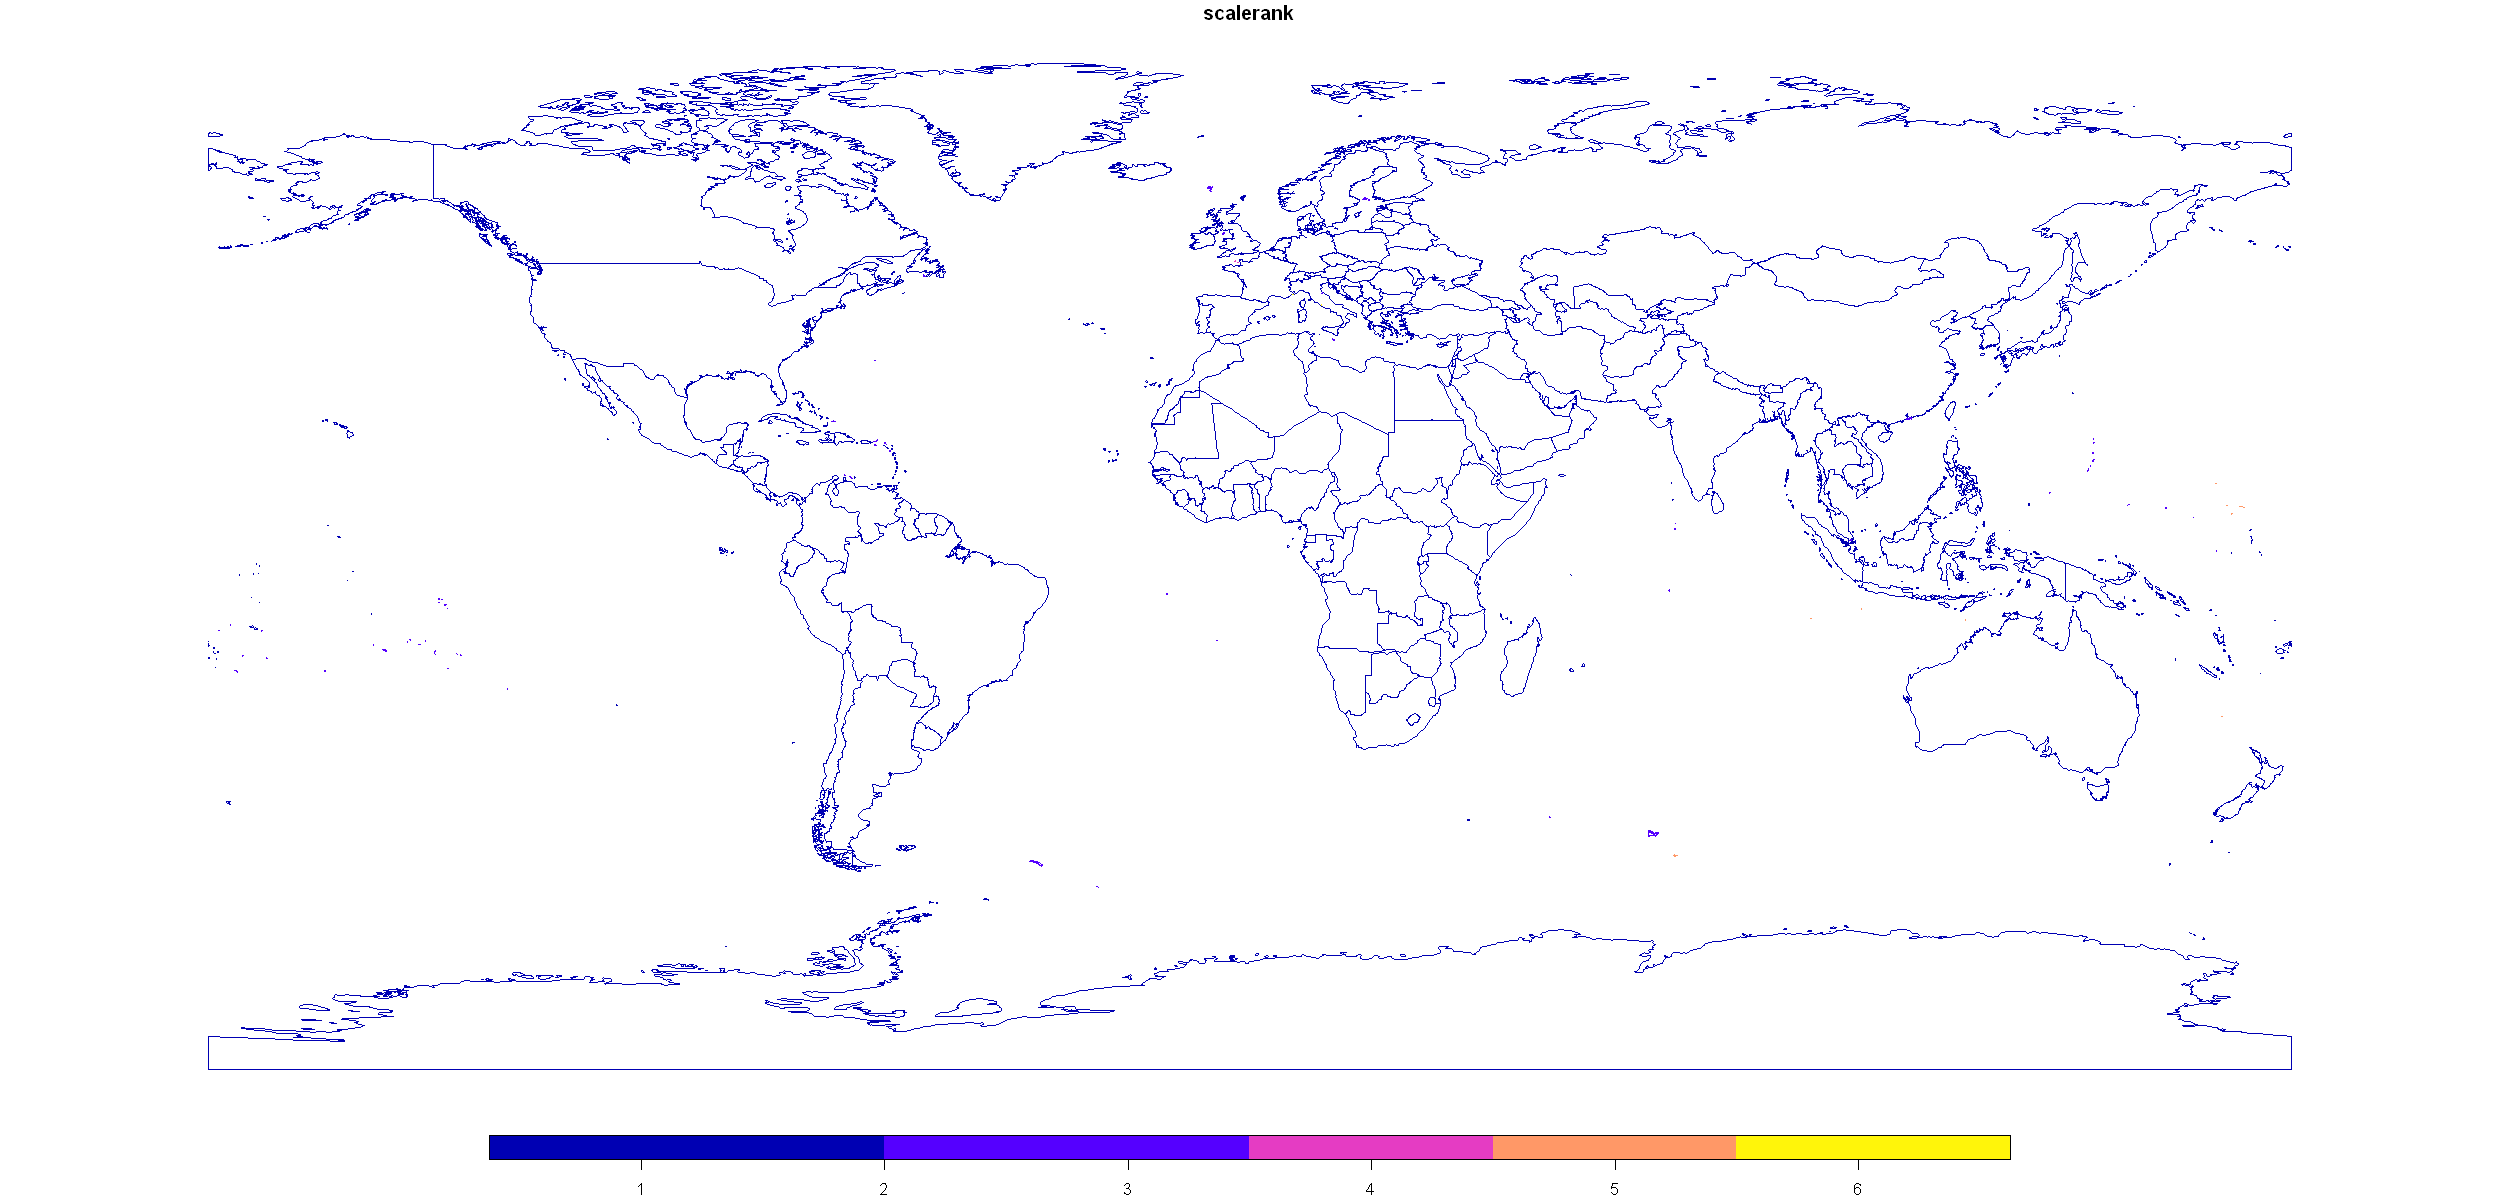

In [36]:
global_map <- ne_countries(scale = 50, returnclass = "sf") %>% st_cast("MULTILINESTRING")
global_map <- global_map[1]
plot(global_map)

although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


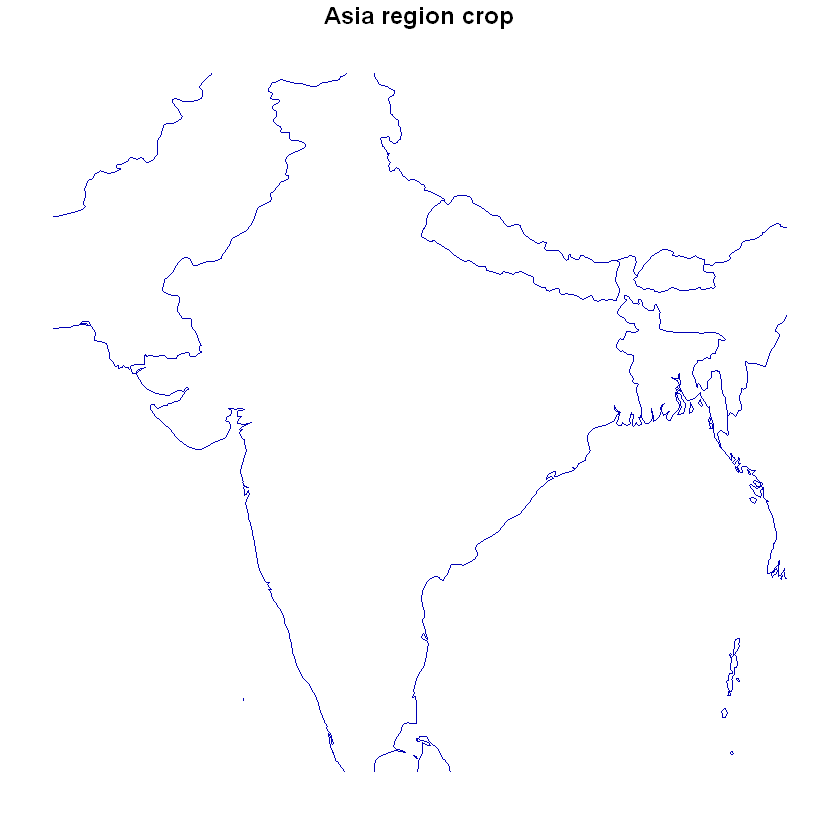

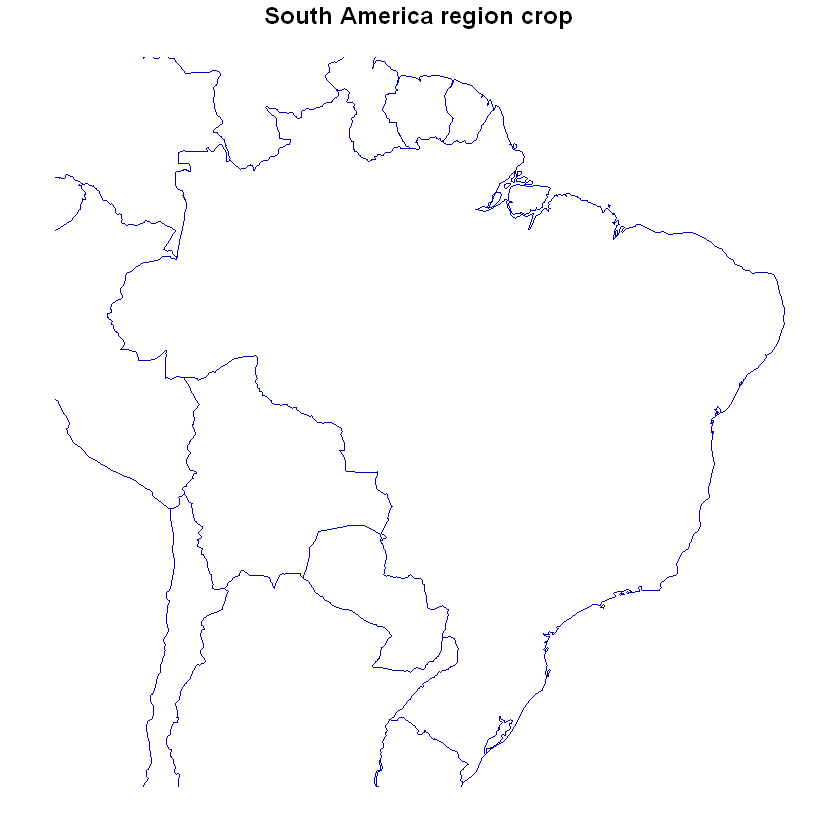

In [18]:
asia_map <- st_crop(global_map, xmin = 65, xmax = 95, ymin = 8.5, ymax = 35)
america_map <- st_crop(global_map, xmin = -77, xmax = -34, ymin = -34, ymax = 7) 


plot(asia_map, main="Asia region crop")
plot(america_map, main="South America region crop")



Now it's the time to visualize the filtered spatial data, to check if it does fit within the areas of interest and get a first glimpse at the distribution of the different types of technology used in soy harvesting

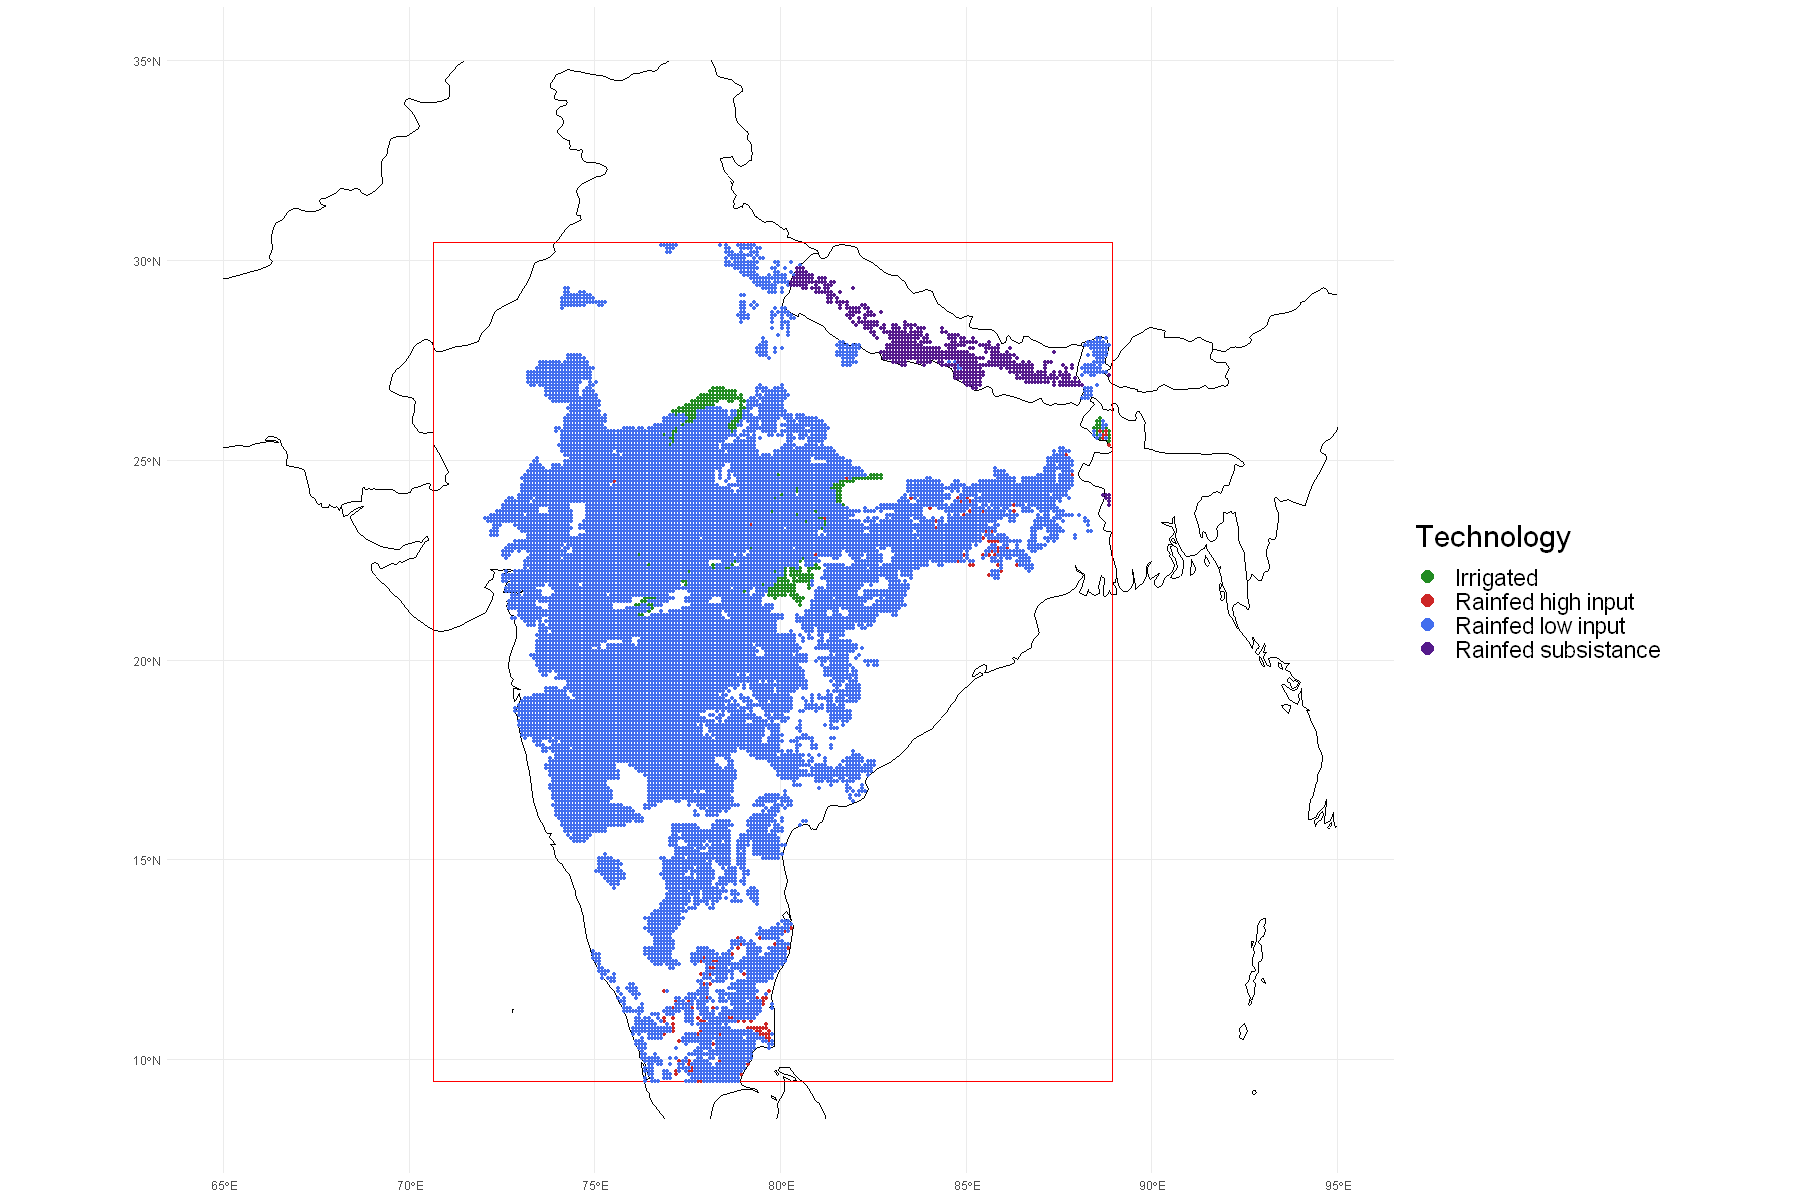

In [20]:
options(repr.plot.width = 18, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = asia_map, fill = "white") +
  geom_sf(data = area_asia,color = "red", fill = NA)+
  geom_sf(data = df_asia, aes(color=Technology), size = 1)+
  scale_color_manual(values = c("Irrigated"= "forestgreen",
                                "Rainfed high input" = "firebrick3",
                                "Rainfed low input" = "royalblue2",
                                "Rainfed subsistance" = "purple4"))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  theme(legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))

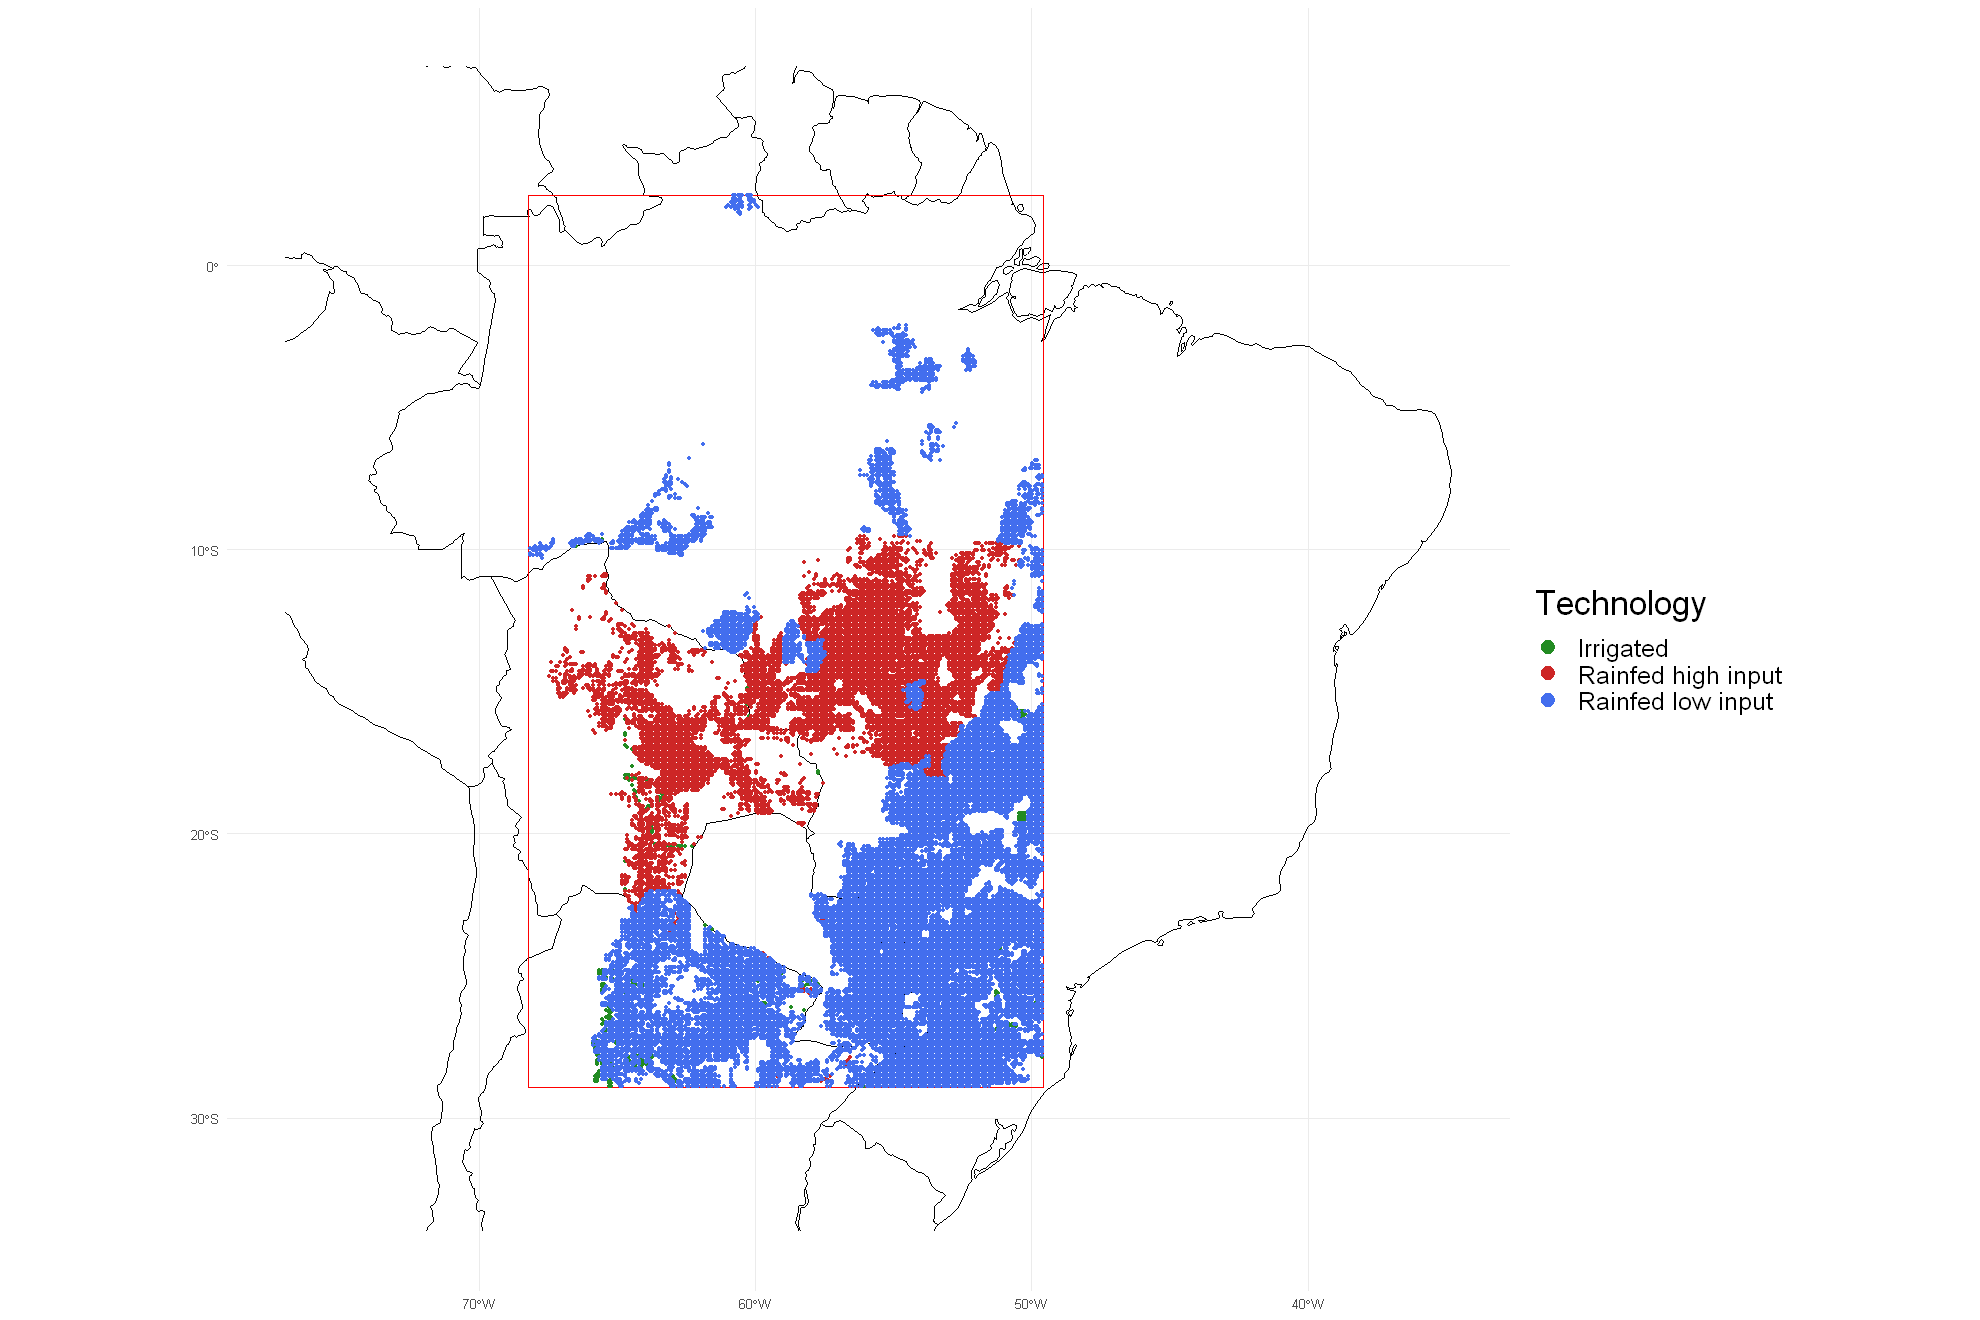

In [22]:
options(repr.plot.width = 18, repr.plot.height = 12, repr.plot.res = 110)
ggplot()+
  geom_sf(data = america_map, fill = "white") +
  geom_sf(data = area_america,color = "red", fill = NA)+
  geom_sf(data = df_america, aes(color=Technology), size = 1)+
  scale_color_manual(values = c("Irrigated"= "forestgreen",
                                "Rainfed high input" = "firebrick3",
                                "Rainfed low input" = "royalblue2",
                                "Rainfed subsistance" = "purple4"))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  theme(legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))

This visualization gives a few first ideas about the data and the crop's situation:  
- Irrigation is likely the technology that covers the least amount of surface, which makes sense considering logistic and economic costs, compared to rainfed crops.
- Subsistance harvesting is only present in Nepal and Bangladesh within the area of interest.
- In South America, areas of high and low inputs rainfed crops seem similar in extension, however...  
- There seems to be a **massive overlap** between technologies in this visualization.  

To get a better idea, it is better to visualize each technology separately


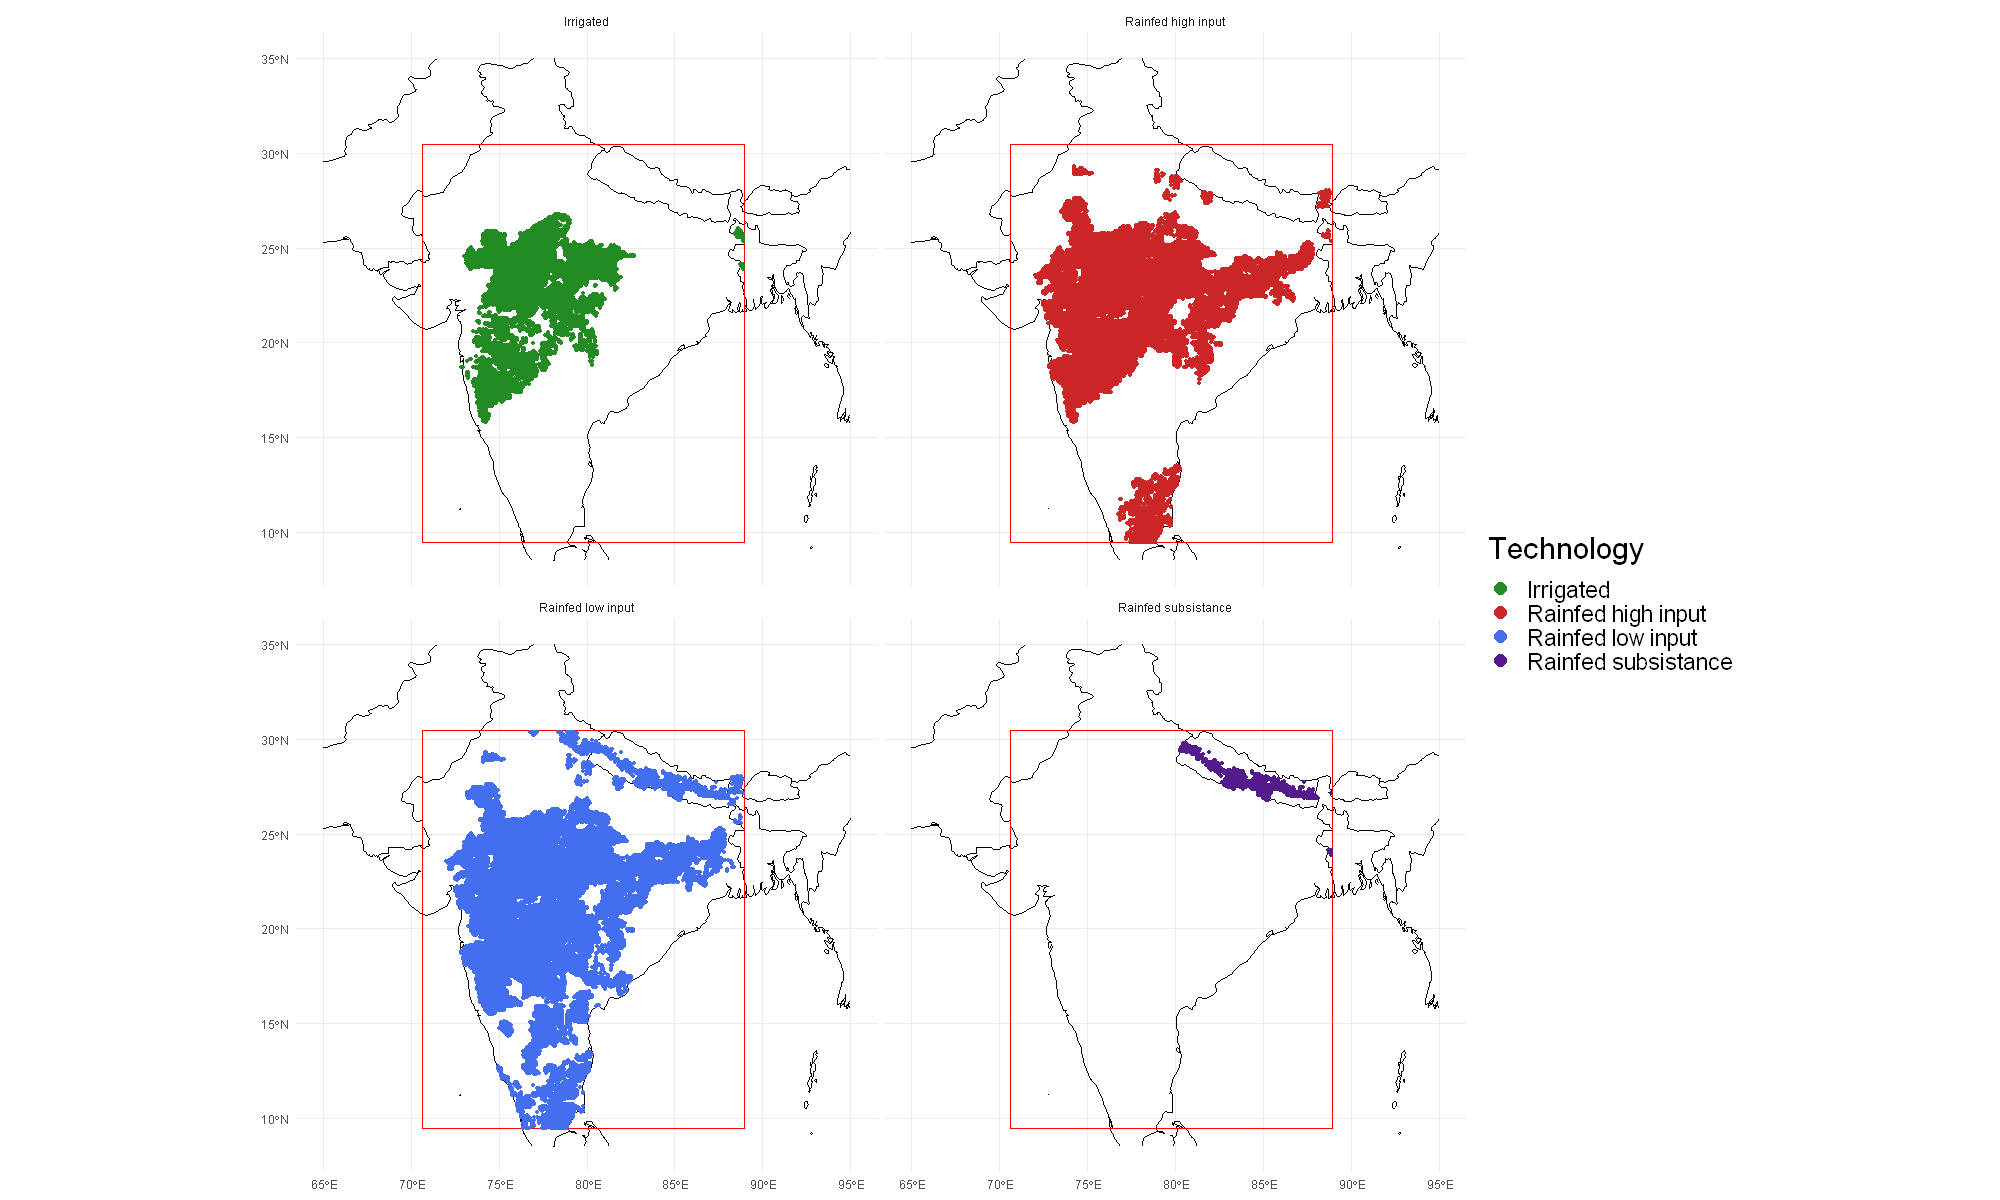

In [25]:
options(repr.plot.width = 20, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = asia_map, fill = "white") +
  geom_sf(data = area_asia,color = "red", fill = NA)+
  geom_sf(data = df_asia, aes(color=Technology), size = 1)+
  scale_color_manual(values = c("Irrigated"= "forestgreen",
                                "Rainfed high input" = "firebrick3",
                                "Rainfed low input" = "royalblue2",
                                "Rainfed subsistance" = "purple4"))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  theme(legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))+
  facet_wrap(~Technology)

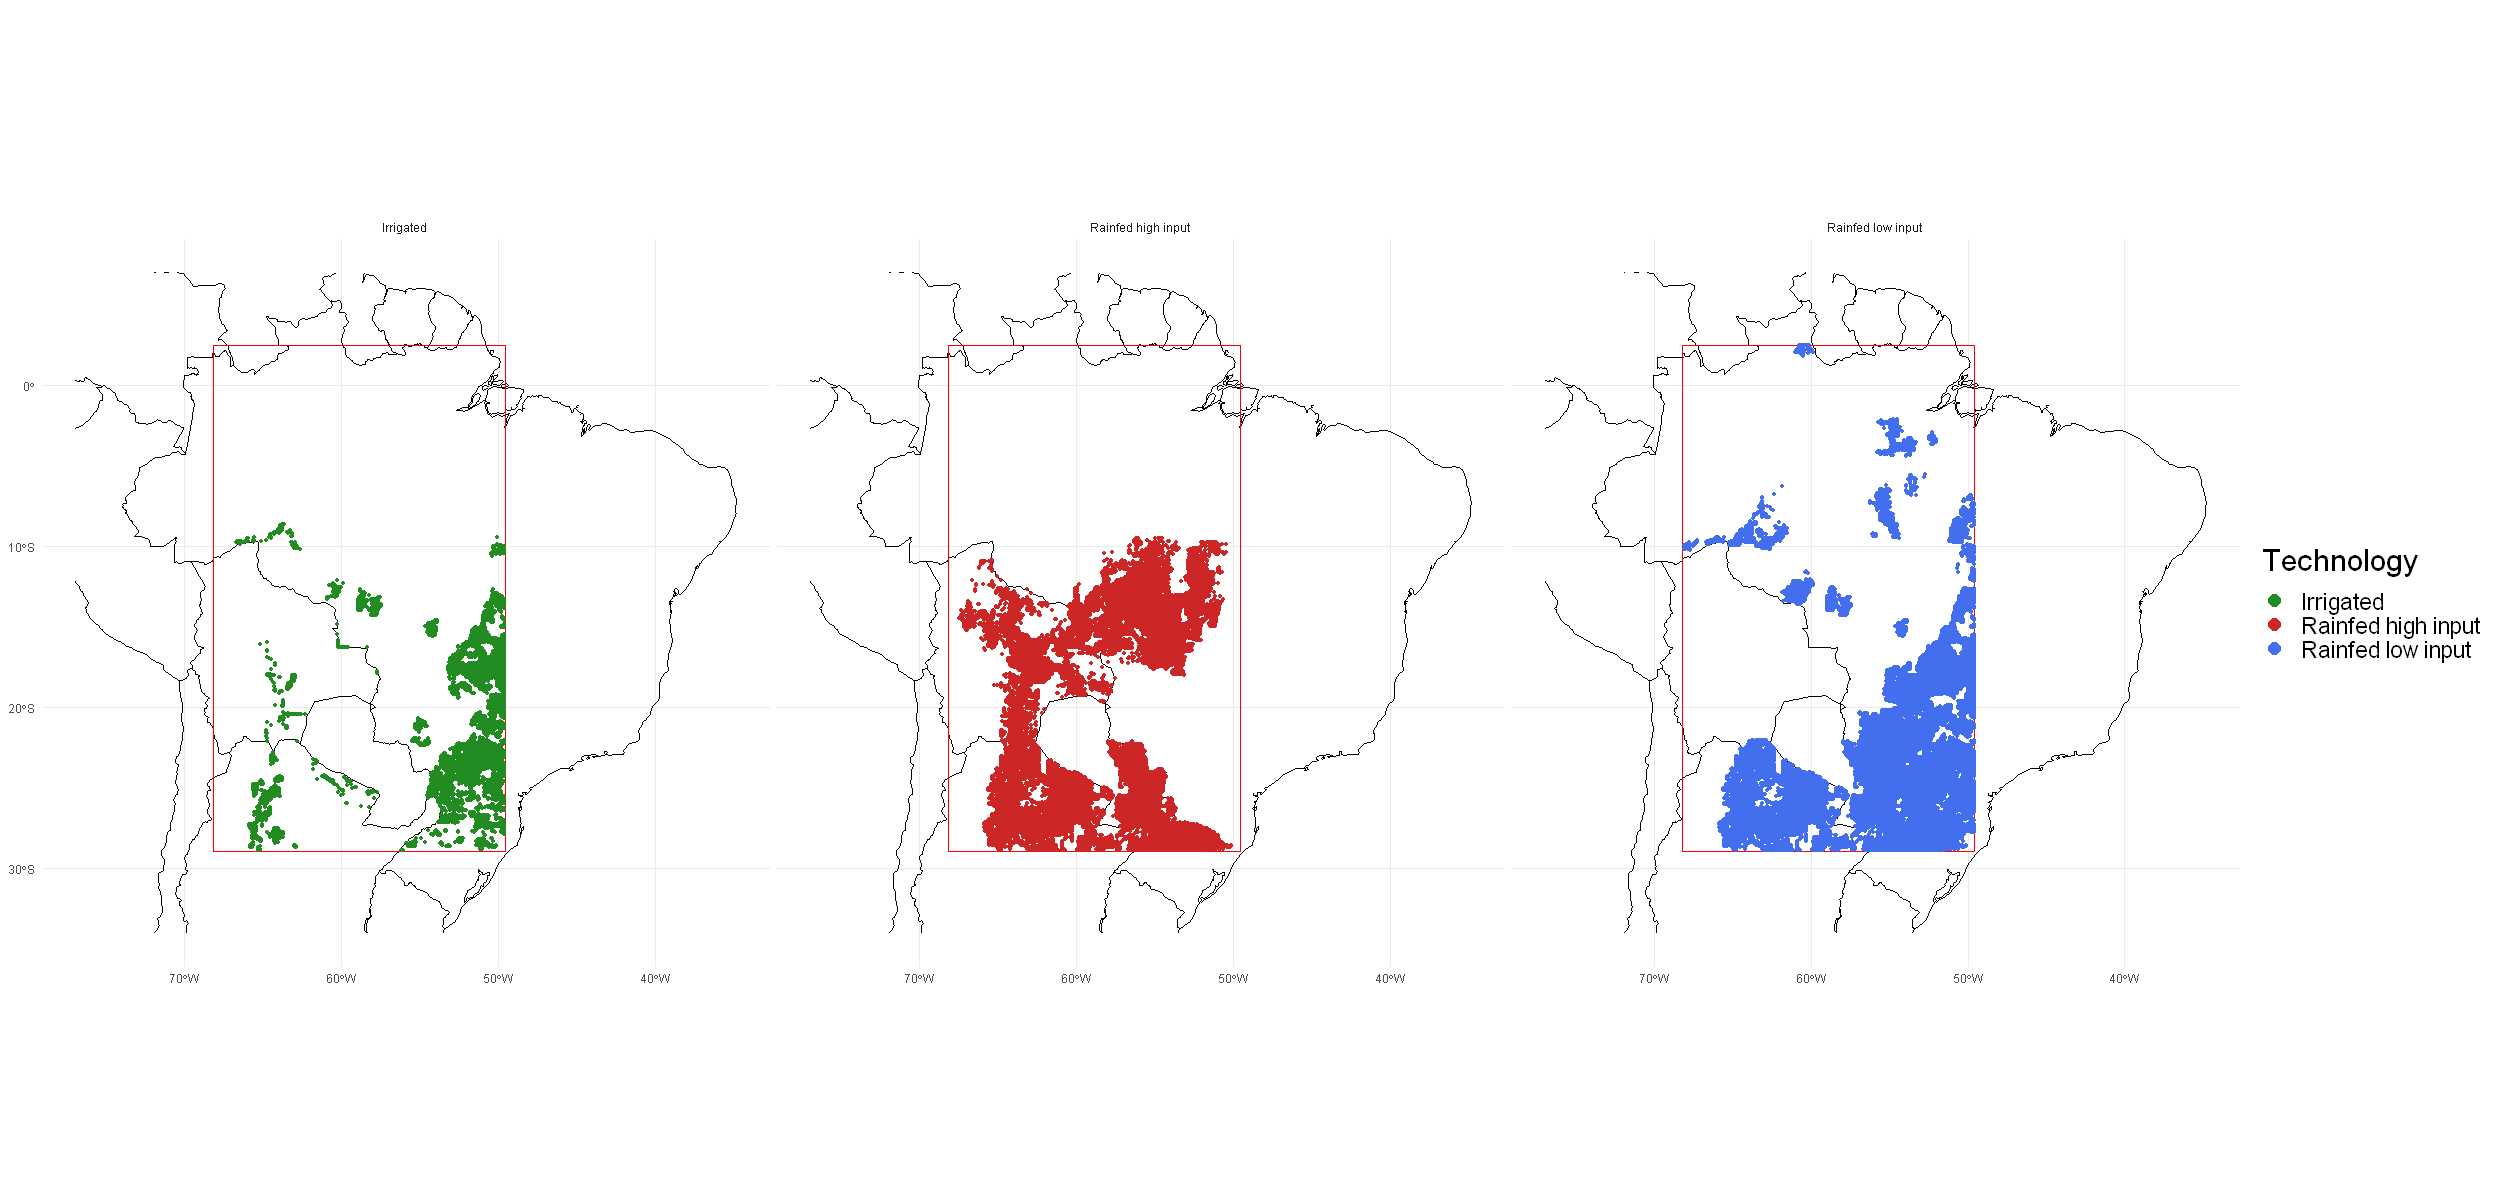

In [26]:
options(repr.plot.width = 25, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = america_map, fill = "white") +
  geom_sf(data = area_america,color = "red", fill = NA)+
  geom_sf(data = df_america, aes(color=Technology), size = 1)+
  scale_color_manual(values = c("Irrigated"= "forestgreen",
                                "Rainfed high input" = "firebrick3",
                                "Rainfed low input" = "royalblue2",
                                "Rainfed subsistance" = "purple4"))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  theme(plot.tag = element_text(size=rel(2)),
        legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))+
  facet_wrap(~Technology)

This visualization confirms that irrigation is the least extended practice, and that in both regions the extension is similar between high and low input rainfed harvesting methods.

## Further data analysis  
To confirm the trends in extension extracted from the plots, I proceed to calculate some basic metrics for each area of interest and technology type.  
I start with a summary table comparing the total area (in hectares) of each technology, as well as the proportion (in percentage) of the total soy crops' area harvested with each method. I also calculated the median surface of harvested land in each pixel (10x10kms) in each case.

In [27]:
df_am <- as.data.frame(df_america) %>% mutate("Region" = "S.America")
df_as <- as.data.frame(df_asia) %>% mutate("Region" = "Asia")

df_g1 <- group_by(df_as, Region, Technology) %>% summarise("Total area (ha)" = sum(soy_beans),
                                                            "Percentage area" = paste0(round((sum(soy_beans)/sum(df_as$soy_beans))*100, 2), "%"),
                                                            "Percentage pixels" = paste0(round(n()/nrow(df_as)*100, 2), "%"),
                                                            "Median area (ha) per pixel" = median(soy_beans))

df_g2 <- group_by(df_am, Region, Technology) %>% summarise("Total area (ha)" = sum(soy_beans),
                                                            "Percentage area" = paste0(round((sum(soy_beans)/sum(df_am$soy_beans))*100, 2), "%"),
                                                            "Percentage pixels" = paste0(round(n()/nrow(df_am)*100, 2), "%"),
                                                            "Median area (ha) per pixel" = median(soy_beans))
df_group <- rbind(df_g1, df_g2)
df_group

`summarise()` has grouped output by 'Region'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Region'. You can override using the `.groups` argument.



Region,Technology,Total area (ha),Percentage area,Percentage pixels,Median area (ha) per pixel
<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Asia,Irrigated,56867.3,0.66%,17.53%,5.6
Asia,Rainfed high input,4853608.1,55.94%,35.24%,37.2
Asia,Rainfed low input,3763800.4,43.38%,45.49%,26.5
Asia,Rainfed subsistance,2563.8,0.03%,1.74%,0.5
S.America,Irrigated,51139.2,0.22%,13.23%,1.0
S.America,Rainfed high input,11517880.1,50.34%,41.63%,197.1
S.America,Rainfed low input,11309608.1,49.43%,45.13%,113.5


While both regions show similar proportions of harvested area with each of the technologies, the most striking aspect is perhaps the amount of harvested hectares per pixel.  
In South America, the rainfed harvested areas contain 4-5 times more harvested hectares than in Asia, which is an indicator of increasing intensive agriculture.
Visualizing the harvested area per pixel for each technology gives an idea of how this trend is distributed.

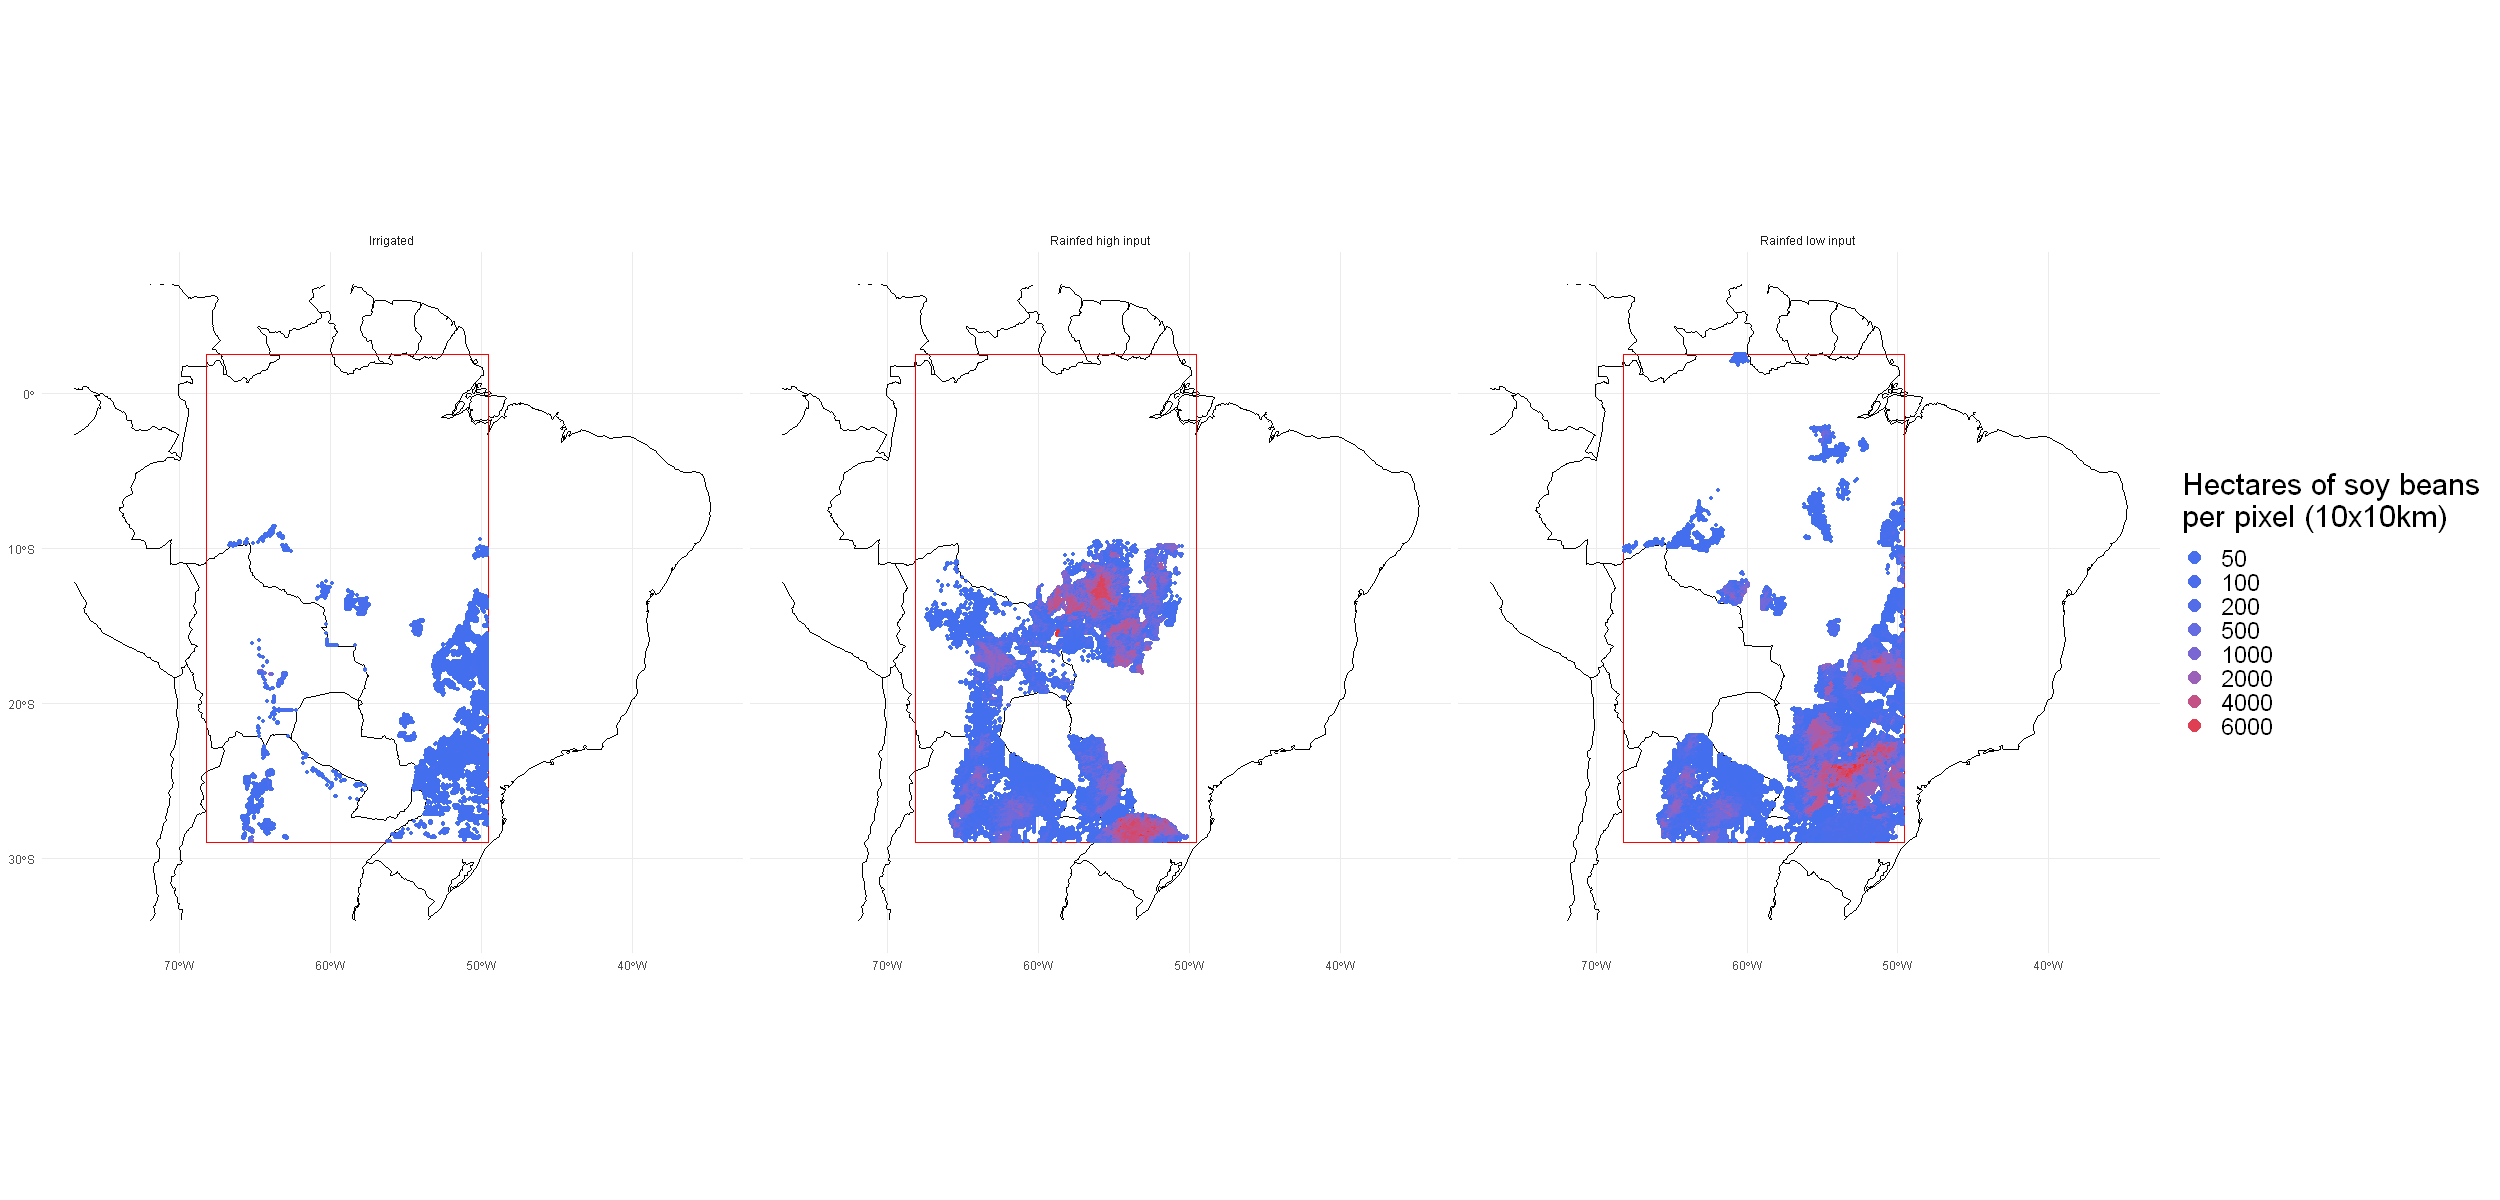

In [31]:
options(repr.plot.width = 25, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = america_map, fill = "white") +
  geom_sf(data = area_america,color = "red", fill = NA)+
  geom_sf(data = df_america, aes(color=soy_beans), size = 1)+
  scale_color_gradient(low="royalblue2", high="firebrick2", breaks = c(50, 100, 200, 500, 1000, 2000, 4000, 6000, 8000))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  labs(color = "Hectares of soy beans\nper pixel (10x10km)")+
  theme(plot.tag = element_text(size=rel(2)),
        legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))+
  facet_wrap(~Technology)

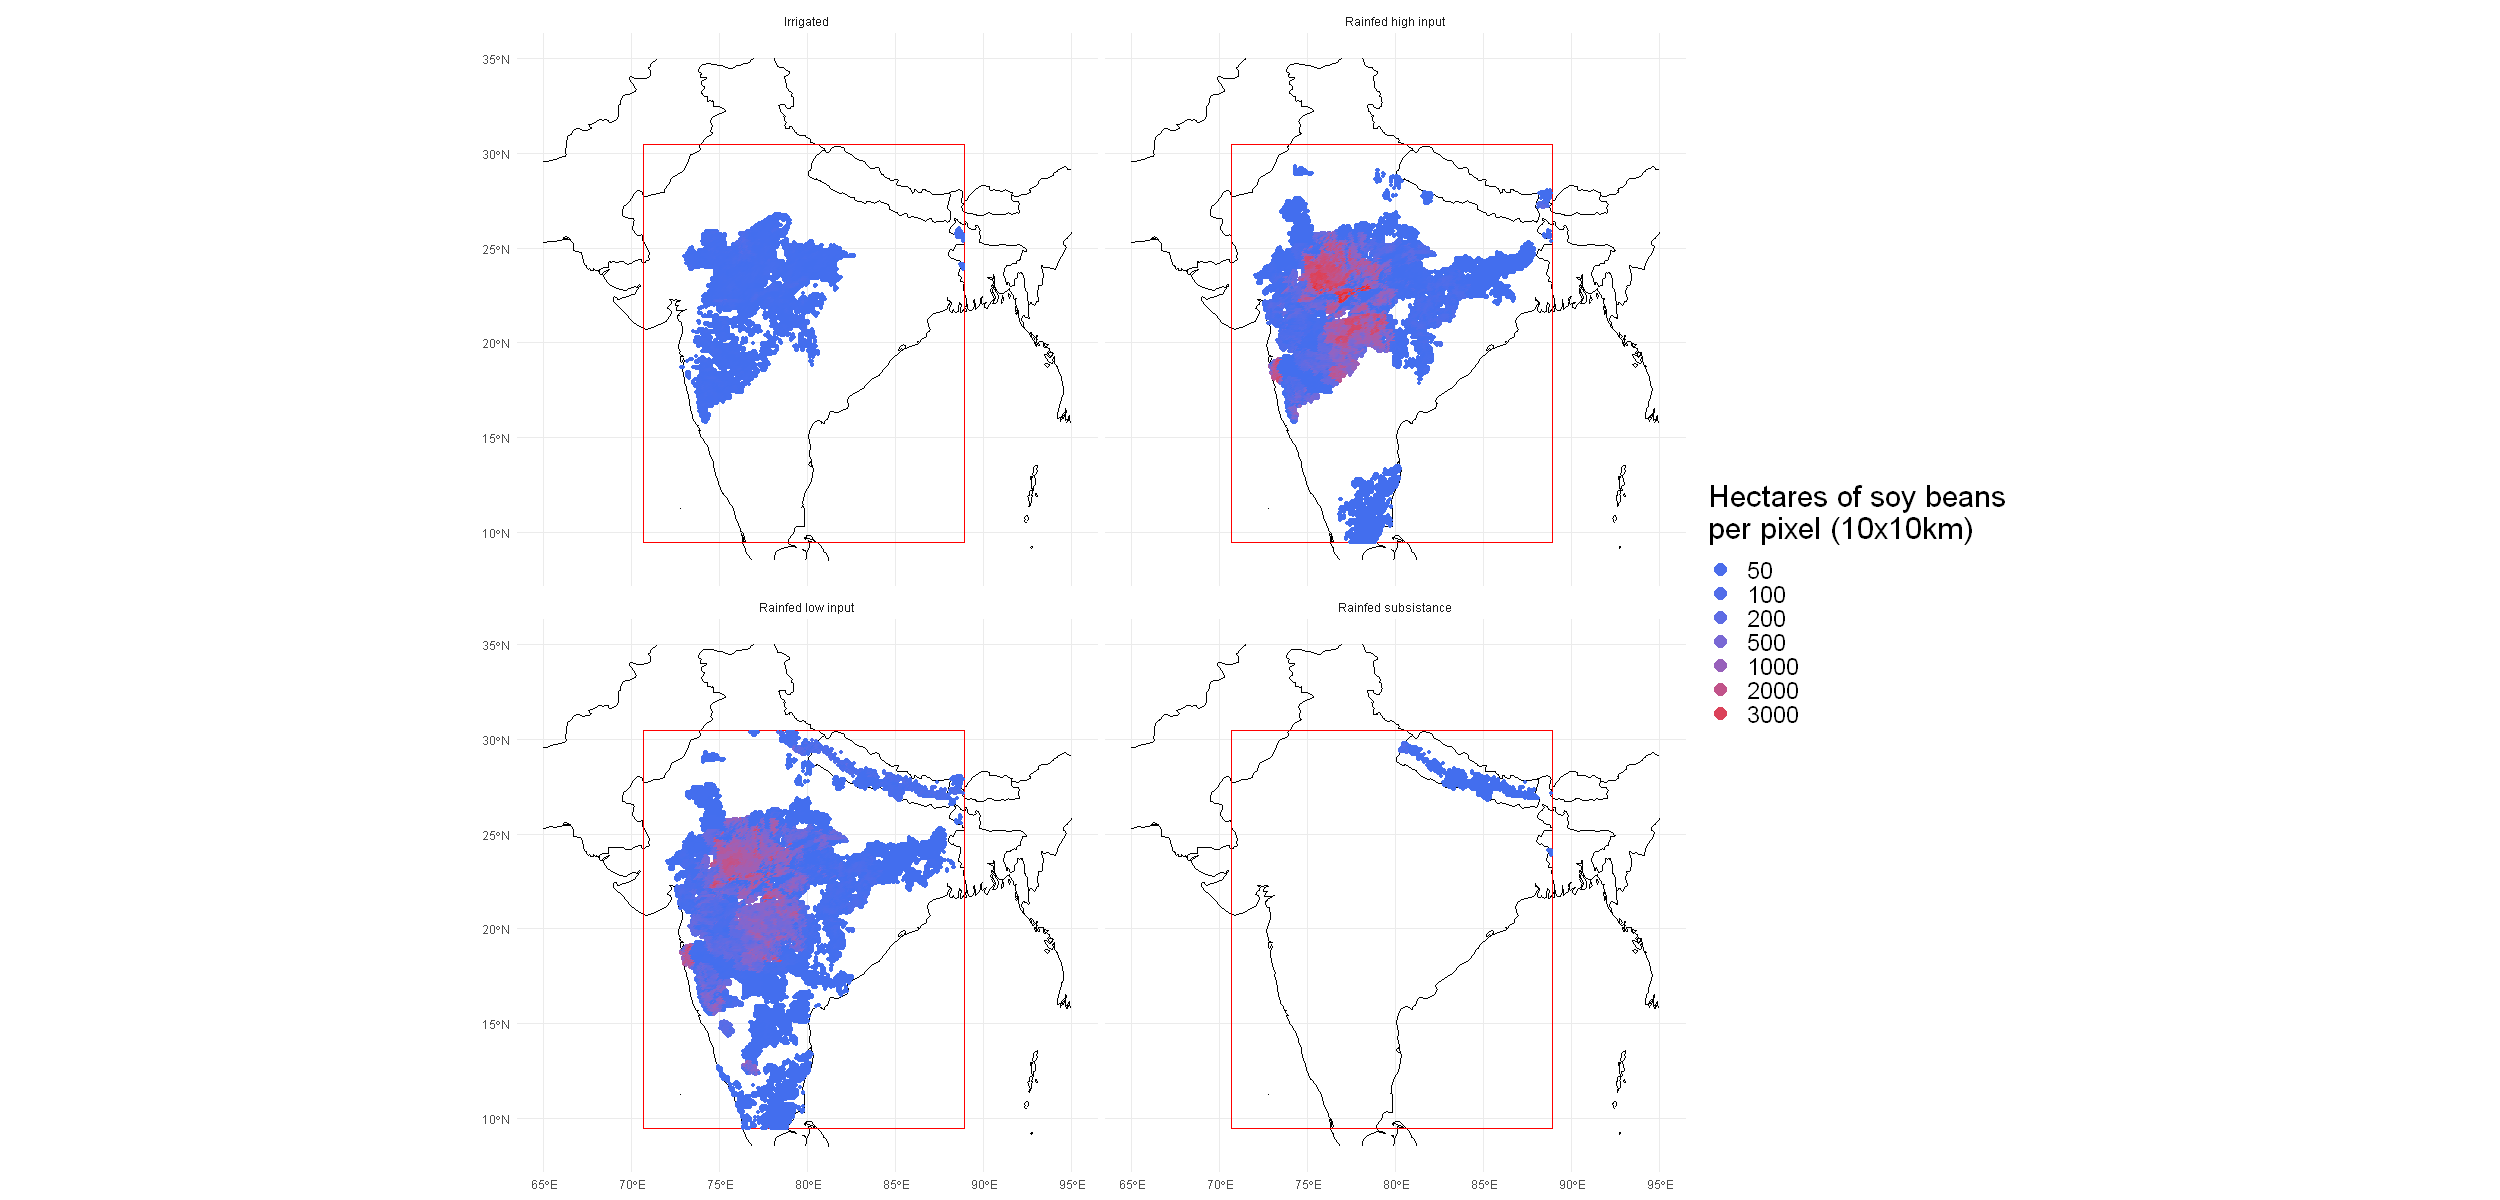

In [33]:
options(repr.plot.width = 25, repr.plot.height = 12, repr.plot.res = 100)
ggplot()+
  geom_sf(data = asia_map, fill = "white") +
  geom_sf(data = area_asia,color = "red", fill = NA)+
  geom_sf(data = df_asia, aes(color=soy_beans), size = 1)+
  scale_color_gradient(low="royalblue2", high="firebrick2", breaks = c(50, 100, 200, 500, 1000, 2000, 3000, 4000, 6000, 8000))+
  guides(color = guide_legend(override.aes = list(size = rel(4))))+
  theme_minimal()+
  labs(color = "Hectares of soy beans\nper pixel (10x10km)")+
  theme(plot.tag = element_text(size=rel(2)),
        legend.title=element_text(size=rel(2)), 
        legend.text=element_text(size=rel(1.5)))+
  facet_wrap(~Technology)

In [32]:
max(df_asia$soy_beans)

[1] 3922.5

The most densely harvested areas in Asia "only" reach ~4000 hectares per pixel (40% of pixel surface), while in South America it goes over 7000 hectares per pixel (70% of pixel surface).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



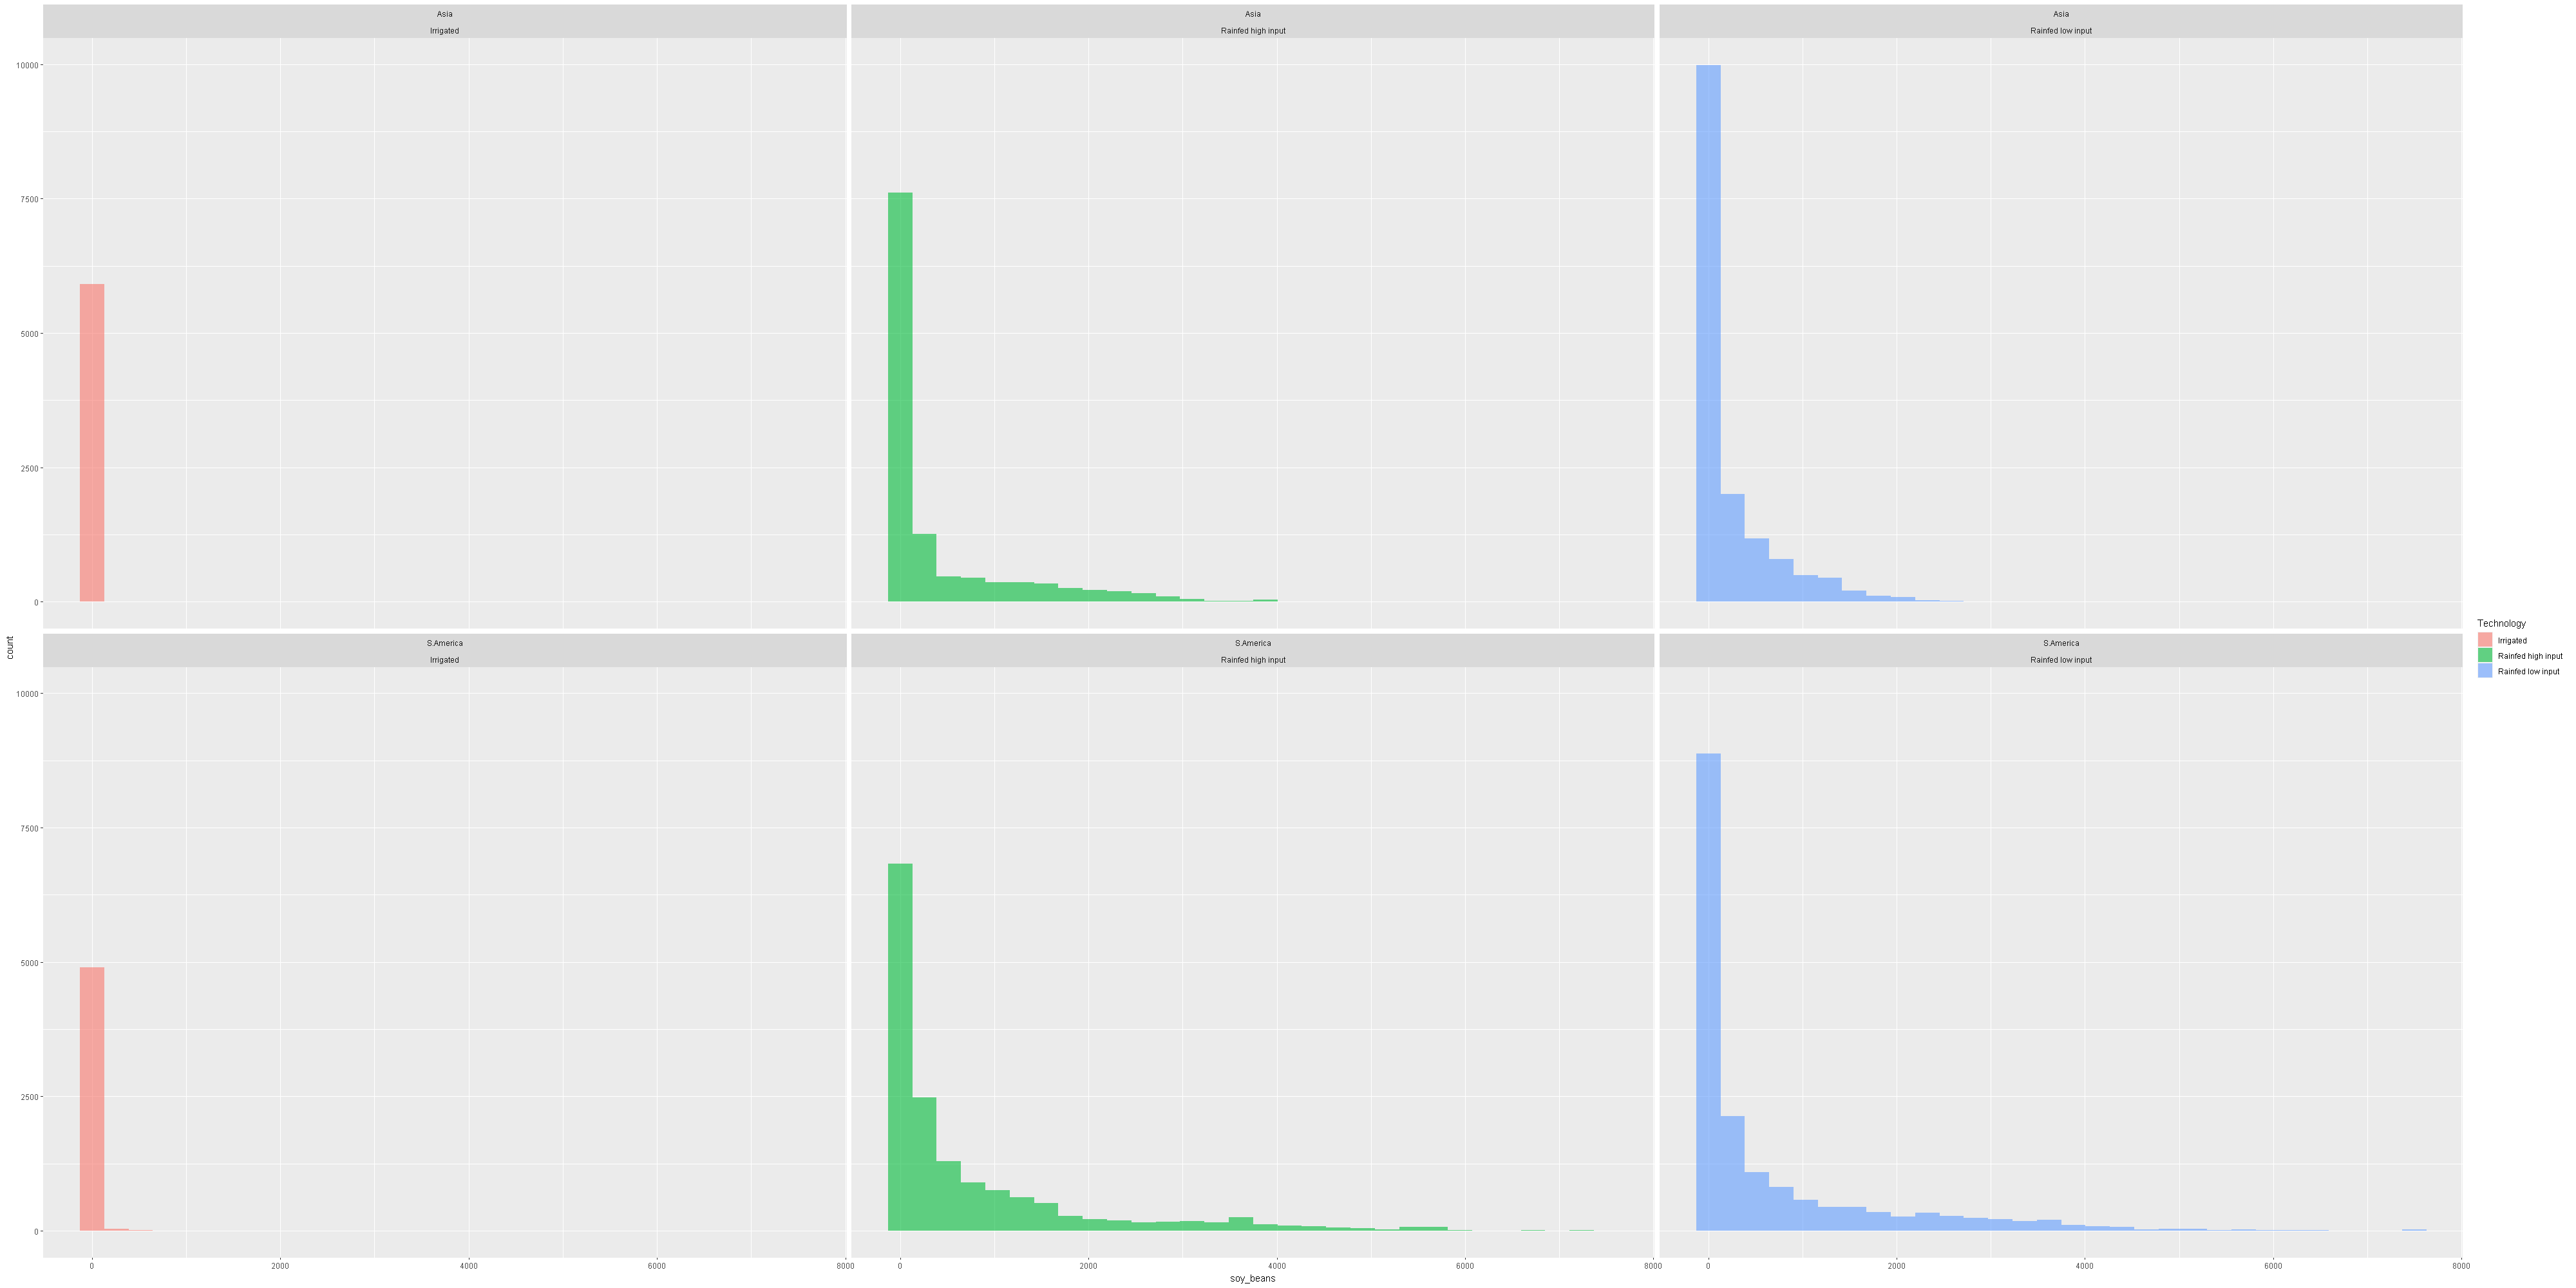

In [52]:
df_joined <- rbind(df_am, df_as) %>% select(soy_beans, Technology, Region) %>% filter(Technology != "Rainfed subsistance")

options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 100)

#ggplot(df_joined, aes(x=Technology, y=soy_beans))+
#    geom_boxplot()+
#    facet_wrap(~Region)

ggplot(df_joined, aes(x=soy_beans, fill=Technology))+
       geom_histogram(alpha=0.6, position = 'identity') +
       facet_wrap(Region~Technology)